# Imports

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

# Read Data

In [3]:
df = pd.read_csv('../02_analysis/df_good.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_14390/882331396.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../02_analysis/df_good.csv')


# Baseline Model

## Data Munge

In [4]:
# Convert 'trial_date' to datetime and sort the dataframe
df['trial_date'] = pd.to_datetime(df['trial_date'])
df_sorted = df.sort_values(by=['PID', 'trial_date'])

# Create shifted columns
df['sr_gap_heuristic_d1'] = df.groupby('PID')['sr_gap_heuristic'].shift(-1)
df['sr_gap_heuristic_d2'] = df.groupby('PID')['sr_gap_heuristic'].shift(-2)
df['sr_gap_heuristic_d3'] = df.groupby('PID')['sr_gap_heuristic'].shift(-3)

In [5]:
cols = [col for col in df.columns if 'heuristic' in col]
cols

['sr_gap_heuristic',
 'sr_gap_heuristic_residual',
 'sr_gap_heuristic_intercept',
 'sr_gap_heuristic_slope',
 'sr_gap_heuristic_d1',
 'sr_gap_heuristic_d2',
 'sr_gap_heuristic_d3']

In [6]:
df[cols]

,sr_gap_heuristic,sr_gap_heuristic_residual,sr_gap_heuristic_intercept,sr_gap_heuristic_slope,sr_gap_heuristic_d1,sr_gap_heuristic_d2,sr_gap_heuristic_d3
0,5.00,-12.693303,17.753776,-0.060473,15.25,46.35,43.70
1,15.25,-2.382829,17.753776,-0.060473,46.35,43.70,45.60
2,46.35,28.777644,17.753776,-0.060473,43.70,45.60,11.55
3,43.70,26.188117,17.753776,-0.060473,45.60,11.55,4.10
4,45.60,28.148591,17.753776,-0.060473,11.55,4.10,17.35
...,...,...,...,...,...,...,...
8920,58.05,16.075780,47.125900,-0.063601,26.25,67.35,52.15
8921,26.25,-15.660619,47.125900,-0.063601,67.35,52.15,NaN
8922,67.35,25.502982,47.125900,-0.063601,52.15,NaN,NaN
8923,52.15,10.366583,47.125900,-0.063601,NaN,NaN,NaN


## RMSE

In [7]:
# Define a function to calculate MSE for a specific lag
def calculate_mse(data, actual, predicted):
    data = data.dropna(subset=[actual, predicted])  # Ensure no NaN values
    rmse = np.sqrt(mean_squared_error(data[actual], data[predicted]))
    return rmse

# Group by 'PID' and apply the MSE calculation for each prediction day
rmse_results = df.groupby('PID').apply(lambda x: pd.Series({
    'RMSE_Day_1': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d1'),
    'RMSE_Day_2': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d2'),
    'RMSE_Day_3': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d3')
})).reset_index()

In [8]:
rmse_results

,PID,RMSE_Day_1,RMSE_Day_2,RMSE_Day_3
0,0151d9f1-1644-4437-805e-02f5e244a690,12.484630,14.869927,14.895803
1,02f48bee-6e86-437c-9394-10ae57dadd14,26.379210,24.527410,25.394194
2,0501ba67-3406-4779-aff1-878a0e9f7885,26.945275,30.797342,32.152243
3,06af7782-cd70-4938-8e67-b6d98b34b665,14.664723,14.417367,18.015907
4,075f7c4e-edea-4d64-8844-f046a1beb770,18.910780,21.273065,19.474681
...,...,...,...,...
100,fb6c8f5a-f92d-4af8-9f87-73ffd4e21f98,24.921687,28.546079,28.667586
101,fc490430-6a41-4853-a2cf-ae0b15265cb6,24.212830,25.429221,26.734689
102,fed3a16b-c5a3-4a84-a111-32b7574e04b5,9.655825,9.885494,8.897692
103,fee5cd07-329a-4f07-bb1a-913dfa09e3b4,19.245491,20.687113,20.787086


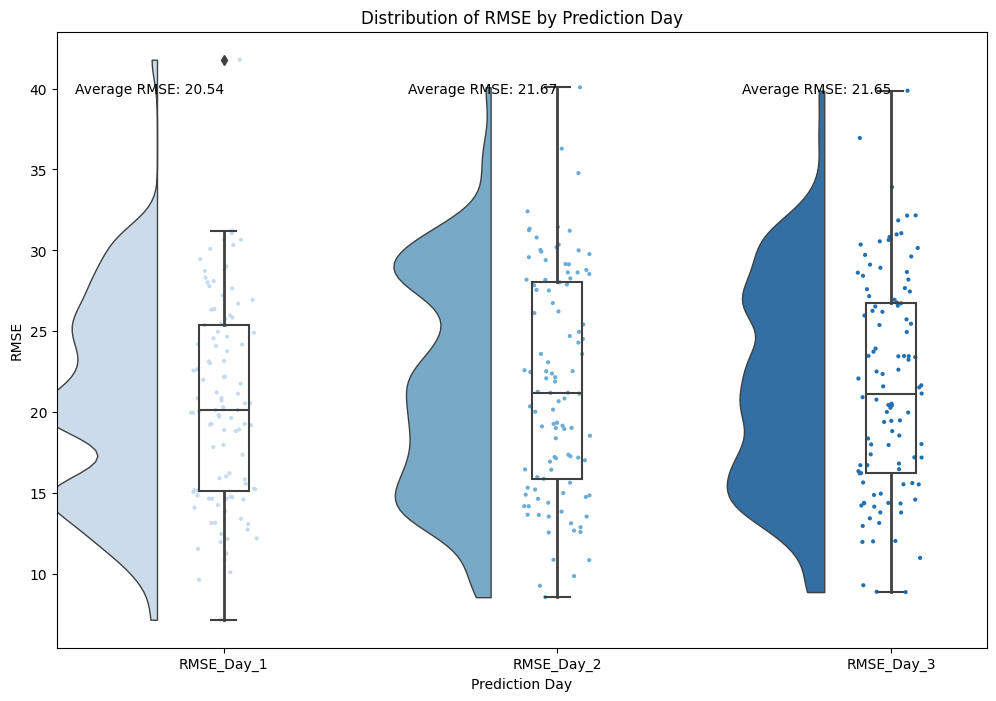

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt

# Melting the dataframe for suitable plotting
plot_data = rmse_results.melt(id_vars=['PID'], var_name='Prediction_Day', value_name='RMSE')

# Calculate average MSE for each day
average_mse = plot_data.groupby('Prediction_Day')['RMSE'].mean().reset_index()
average_mse['label'] = average_mse['RMSE'].apply(lambda x: f'Average RMSE: {x:.2f}')

# Creating a raincloud plot
plt.figure(figsize=(12, 8))
ax = pt.RainCloud(data=plot_data, x='Prediction_Day', y='RMSE', palette='Blues', bw=0.2)

# Title and labels
plt.title('Distribution of RMSE by Prediction Day')
plt.xlabel('Prediction Day')
plt.ylabel('RMSE')

# Adding average MSE labels to the plot
for i, row in average_mse.iterrows():
    plt.text(x=i, y=plot_data['RMSE'].max() * .95, s=row['label'], horizontalalignment='right')

plt.show()

## Correlation

In [10]:
from scipy.stats import pearsonr

def calculate_correlation(data, actual, predicted):
    valid_data = data.dropna(subset=[actual, predicted])
    if len(valid_data) < 2:
        return np.nan  # Return NaN if not enough data to calculate correlation
    correlation, _ = pearsonr(valid_data[actual], valid_data[predicted])
    return correlation

# Group by 'PID' and apply the correlation calculation for each prediction day
correlation_results = df.groupby('PID').apply(lambda x: pd.Series({
    'Correlation_Day_1': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d1'),
    'Correlation_Day_2': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d2'),
    'Correlation_Day_3': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d3')
})).reset_index()

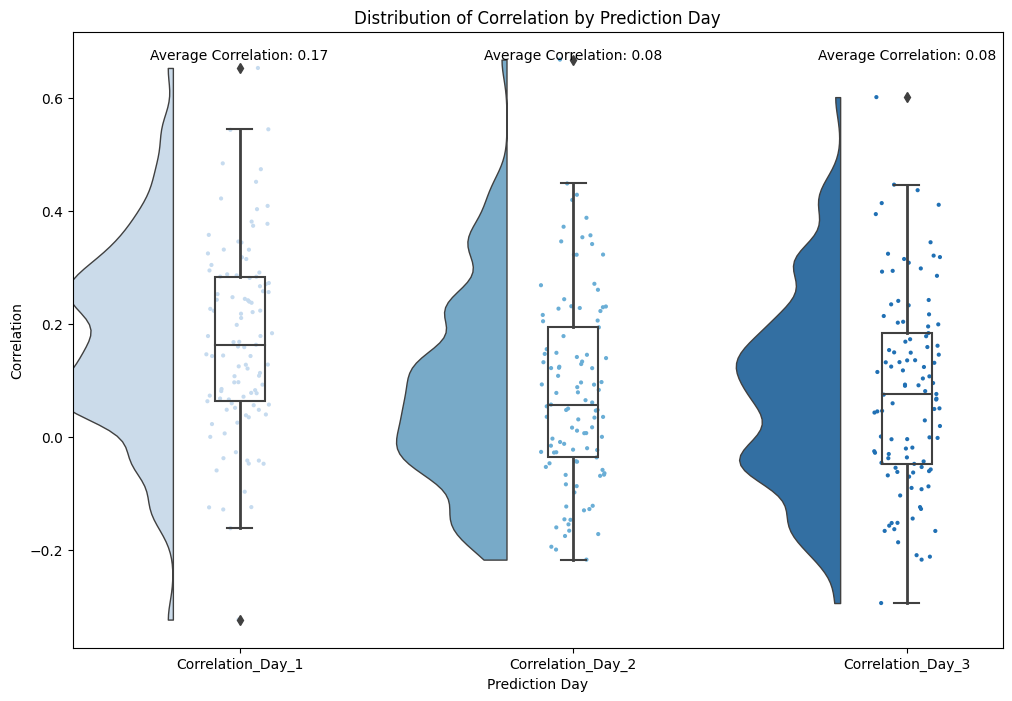

In [11]:
# Melting the dataframe for suitable plotting
plot_data = correlation_results.melt(id_vars=['PID'], var_name='Prediction_Day', value_name='Correlation')

# Calculate average correlation for each day
average_corr = plot_data.groupby('Prediction_Day')['Correlation'].mean().reset_index()
average_corr['label'] = average_corr['Correlation'].apply(lambda x: f'Average Correlation: {x:.2f}')

# Creating a raincloud plot
plt.figure(figsize=(12, 8))
ax = pt.RainCloud(data=plot_data, x='Prediction_Day', y='Correlation', palette='Blues', bw=0.2)

# Title and labels
plt.title('Distribution of Correlation by Prediction Day')
plt.xlabel('Prediction Day')
plt.ylabel('Correlation')

# Adding average correlation labels to the plot
for i, row in average_corr.iterrows():
    plt.text(x=i, y=plot_data['Correlation'].max(), s=row['label'], horizontalalignment='center')

plt.show()

# Mixed Effects Models

## Gap

In [12]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

results = {}
pred_columns = ['sr_gap_heuristic_d1', 'sr_gap_heuristic_d2', 'sr_gap_heuristic_d3']
for col in pred_columns:
    model = MixedLM(df_pred[col], df_pred[['sr_gap_heuristic']], groups=df_pred['PID'])
    result = model.fit()
    df_pred[col + '_pred'] = result.fittedvalues  # Store predictions for RMSE calculation
    results[col] = result

# Output the summary of one of the models if needed
print(results['sr_gap_heuristic_d1'].summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_heuristic_d1
No. Observations: 6988    Method:             REML               
No. Groups:       105     Scale:              268.4983           
Min. group size:  21      Log-Likelihood:     -29758.8843        
Max. group size:  81      Converged:          Yes                
Mean group size:  66.6                                           
-----------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
sr_gap_heuristic        0.197    0.012 16.561 0.000  0.174  0.220
Group Var            1233.337   10.744                           



In [13]:
rmse_scores = {}
for col in pred_columns:
    actual = df_pred[col].dropna()
    predicted = df_pred[col + '_pred'][actual.index]  # Ensure alignment of indices
    mse = mean_squared_error(actual, predicted)
    rmse_scores[col] = np.sqrt(mse)

# Display the RMSE scores
print(rmse_scores)

{'sr_gap_heuristic_d1': 16.261564564708788, 'sr_gap_heuristic_d2': 16.48465638065982, 'sr_gap_heuristic_d3': 16.33214734067258}


## Gap + Net Affect

In [14]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3',
        'sr_affect_net_avg'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

results = {}
pred_columns = ['sr_gap_heuristic_d1', 'sr_gap_heuristic_d2', 'sr_gap_heuristic_d3']
for col in pred_columns:
    model = MixedLM(df_pred[col], df_pred[['sr_gap_heuristic', 'sr_affect_net_avg']], groups=df_pred['PID'])
    result = model.fit()
    df_pred[col + '_pred'] = result.fittedvalues  # Store predictions for RMSE calculation
    results[col] = result

# Output the summary of one of the models if needed
print(results['sr_gap_heuristic_d1'].summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_heuristic_d1
No. Observations: 6823    Method:             REML               
No. Groups:       105     Scale:              267.8141           
Min. group size:  16      Log-Likelihood:     -29051.1780        
Max. group size:  81      Converged:          Yes                
Mean group size:  65.0                                           
-----------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
sr_gap_heuristic        0.210    0.013 16.663 0.000  0.186  0.235
sr_affect_net_avg       0.573    0.245  2.340 0.019  0.093  1.053
Group Var            1189.945   10.440                           



In [15]:
rmse_scores = {}
for col in pred_columns:
    actual = df_pred[col].dropna()
    predicted = df_pred[col + '_pred'][actual.index]  # Ensure alignment of indices
    mse = mean_squared_error(actual, predicted)
    rmse_scores[col] = np.sqrt(mse)

# Display the RMSE scores
print(rmse_scores)

{'sr_gap_heuristic_d1': 16.236674085423978, 'sr_gap_heuristic_d2': 16.488029222619012, 'sr_gap_heuristic_d3': 16.273360147514058}


# ML Models

### Feature Engineering

In [16]:
# Example feature engineering: Mean encoding for PIDs
pid_mean = df.groupby('PID')['sr_gap_heuristic'].transform('mean')
df['sr_gap_heuristic_mean'] = pid_mean

pid_mean = df.groupby('PID')['sr_affect_net_avg'].transform('mean')
df['sr_affect_subject_mean'] = pid_mean

df['sr_gap_heuristic_residual'] = df['sr_gap_heuristic'] - df['sr_gap_heuristic_mean']
df['sr_affect_residual'] = df['sr_affect_net_avg'] - df['sr_affect_subject_mean']

In [18]:
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3',
        'sr_affect_net_avg',
        'sr_gap_heuristic_mean',
        'sr_gap_heuristic_residual',
        'sr_affect_subject_mean',
        'sr_affect_residual'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

## Gradient Boosted | Affect + Gap

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 6
[LightGBM] [Info] Start training from score 42.923862
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 15.6652	valid_0's l2: 245.399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1126
[LightGBM] [Info] Number of data points in the train set: 5457, number of used features: 6
[LightGBM] [Info] Start training from score 41.638802
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 17.2657	valid_0's l2: 298.103
[LightGBM] [Info] Auto-c

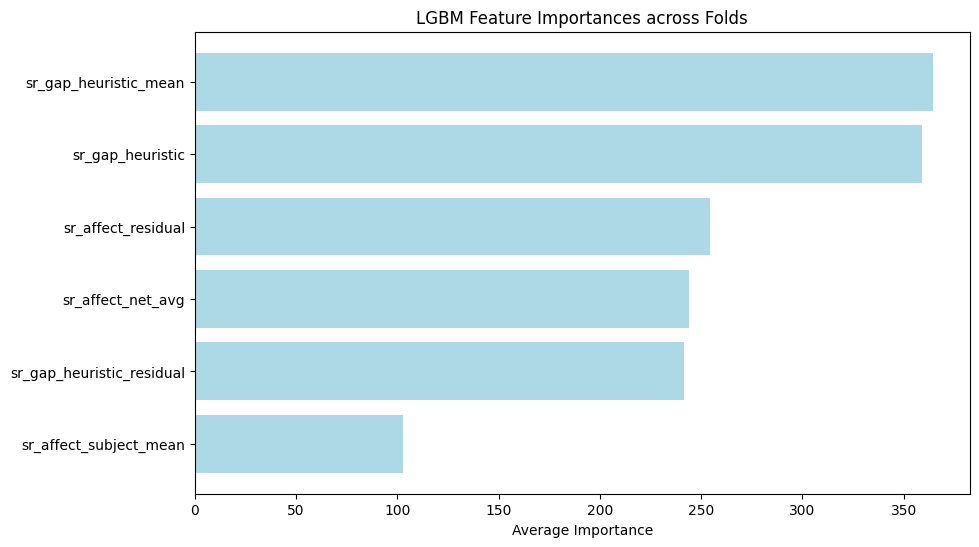

In [23]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from lightgbm.callback import early_stopping

# Prepare features and target
X = df_pred[['sr_gap_heuristic', 'sr_affect_net_avg', 'sr_gap_heuristic_mean', 'sr_gap_heuristic_residual', 'sr_affect_subject_mean', 'sr_affect_residual']]  # plus other features as needed
y = df_pred['sr_gap_heuristic_d1']  # Predicting Day 1 gap as an example
groups = df_pred['PID']

# Setup Group K-Fold to respect PID groups
gkf = GroupKFold(n_splits=5)

# Define the model
model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)

# Prepare to store feature importances
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

rmse_scores = []

# Perform group k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[early_stopping(10)]
    )
    
    # Use the best iteration to make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    
    # Calculate RMSE and append to list
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    # Get feature importances
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X.columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold + 1
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)


# Output the RMSE scores
print("RMSE scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

# Compute average feature importances across all folds
average_importances = feature_importances.groupby('feature').mean().sort_values(by="importance", ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.title('LGBM Feature Importances across Folds')
plt.barh(average_importances.index, average_importances['importance'], color='lightblue')
plt.xlabel('Average Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

## Same Day

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 4
[LightGBM] [Info] Start training from score 42.960721
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 15.2621	valid_0's l2: 232.933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 5457, number of used features: 4
[LightGBM] [Info] Start training from score 41.624255
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's rmse: 17.0831	valid_0's l2: 291.832
[LightGBM] [Info] Auto-cho

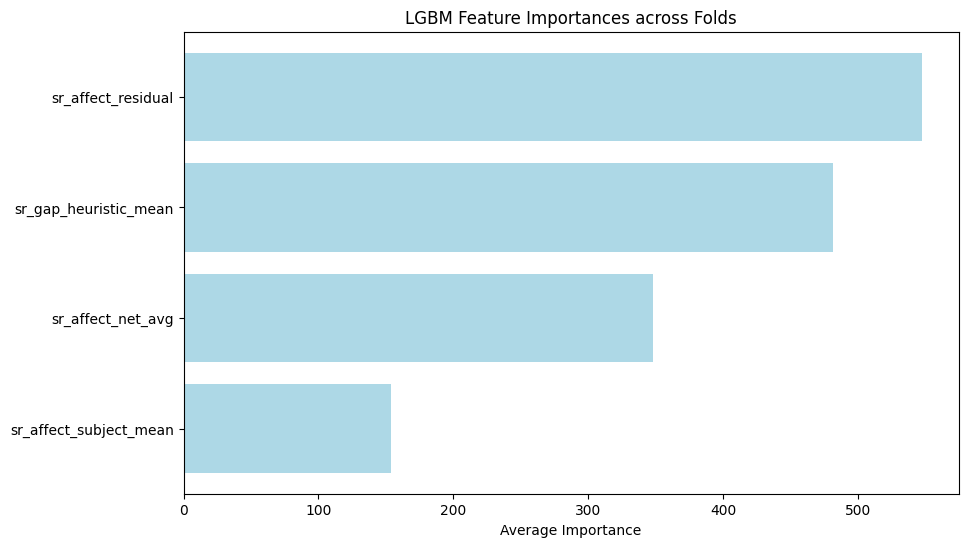

In [26]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from lightgbm.callback import early_stopping

# Prepare features and target
X = df_pred[['sr_affect_net_avg', 'sr_gap_heuristic_mean', 'sr_affect_subject_mean', 'sr_affect_residual']]  # plus other features as needed
y = df_pred['sr_gap_heuristic']  # Predicting Day 1 gap as an example
groups = df_pred['PID']

# Setup Group K-Fold to respect PID groups
gkf = GroupKFold(n_splits=5)

# Define the model
model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)

# Prepare to store feature importances
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

rmse_scores = []

# Perform group k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[early_stopping(10)]
    )
    
    # Use the best iteration to make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    
    # Calculate RMSE and append to list
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    # Get feature importances
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X.columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold + 1
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)


# Output the RMSE scores
print("RMSE scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

# Compute average feature importances across all folds
average_importances = feature_importances.groupby('feature').mean().sort_values(by="importance", ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.title('LGBM Feature Importances across Folds')
plt.barh(average_importances.index, average_importances['importance'], color='lightblue')
plt.xlabel('Average Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

## Location

- Fix timing
- Look at raw data

## Weekly Effects
- mimic the paper Cendri sent?

# Within-Subject Rationale

# PLAN

## Feature Selection

- How to use the goals that are set? Use the embeddings?

### Select Subject

In [143]:
sub = 1

subject = np.unique(df.PID)[sub-1]

print(f'Subject {subject} selected.')

Subject 0151d9f1-1644-4437-805e-02f5e244a690 selected.


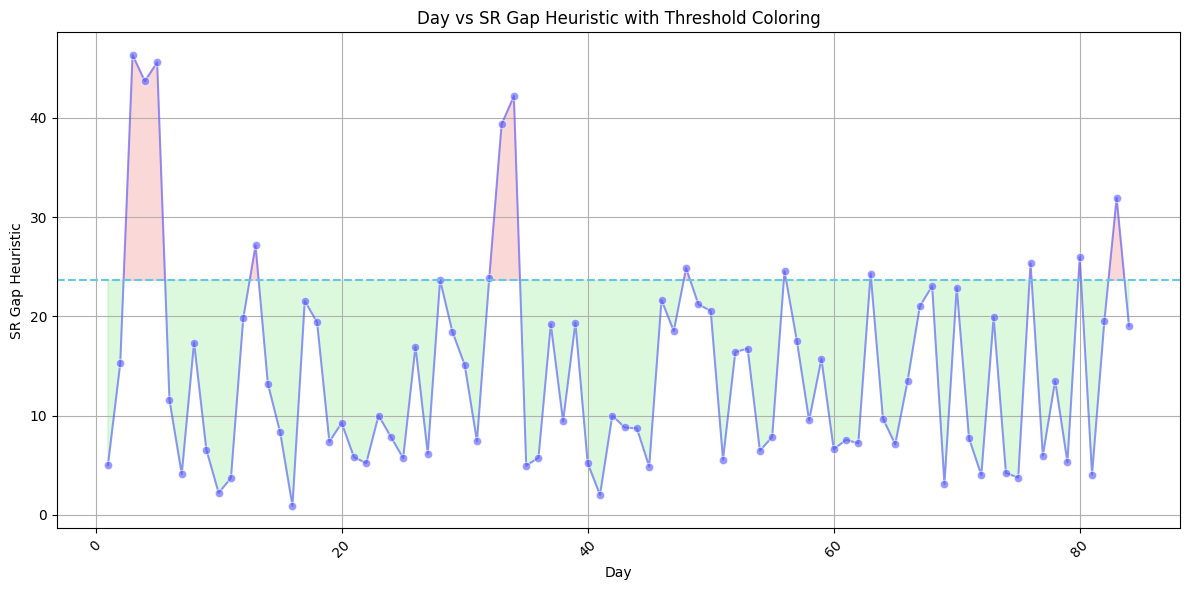

In [144]:
df_sub = df.loc[df.PID == subject]

# Calculate the midpoint value between max and min of sr_gap_heuristic
max_val = df_sub['sr_gap_heuristic'].max()
min_val = df_sub['sr_gap_heuristic'].min()
mid_val = (max_val + min_val) / 2

# Creating the plot
plt.figure(figsize=(12, 6))
# Plotting all data points
sns.lineplot(x='day', y='sr_gap_heuristic', data=df_sub, color="#5356FF", alpha=0.6, marker='o')

# Add a horizontal line at the threshold
plt.axhline(y=mid_val, color='#67C6E3', linestyle='--')
plt.fill_between(df_sub['day'], df_sub['sr_gap_heuristic'], mid_val, where=(df_sub['sr_gap_heuristic'] <= mid_val), 
                 interpolate=True, color='lightgreen', alpha=0.3)
plt.fill_between(df_sub['day'], df_sub['sr_gap_heuristic'], mid_val, where=(df_sub['sr_gap_heuristic'] > mid_val), 
                 interpolate=True, color='lightcoral', alpha=0.3)

plt.title('Day vs SR Gap Heuristic with Threshold Coloring')
plt.xlabel('Day')
plt.ylabel('SR Gap Heuristic')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Cleaning

In [197]:
# Convert all columns to numeric, setting errors='coerce' will convert non-convertible values to NaN
df_numeric = df.loc[df.PID == subject].apply(pd.to_numeric, errors='coerce')

# Remove columns with NaN counts about threshold
threshold_nan = 0.5

nan_counts = df_numeric.isna().sum()
cols_to_drop_due_to_nans = nan_counts[nan_counts > len(df_numeric) * threshold_nan].index
df_numeric = df_numeric.drop(columns=cols_to_drop_due_to_nans)

print(f'Removed due to NaNs:')
for item in cols_to_drop_due_to_nans:
    print(item)

Removed due to NaNs:
PID
affect_pct_zeroVarRows
affect_zeroVarRows_flag
sr_DAILY_goal1_interaction_month
sr_DAILY_goal1_interaction_week
sr_DAILY_goal1_set
sr_DAILY_goal2_interaction_month
sr_DAILY_goal2_interaction_week
sr_DAILY_goal2_set
sr_DAILY_next24_drinks
sr_DAILY_next24_leisureNonSolo
sr_DAILY_next24_leisureSolo
sr_DAILY_next24_nonoccupation
sr_DAILY_next24_socialMedia
sr_DAILY_past24_diet
sr_DAILY_past24_gapCause
sr_DAILY_past48to24_gap
sr_DAILY_past48to24_gapCause
sr_DAILY_survey_missed
sr_DAILY_survey_situation1_surveys
sr_DAILY_survey_situation2_surveys
sr_IDEAL_values_monthly1
sr_IDEAL_values_monthly2
sr_IDEAL_values_monthly3
sr_MONTHLY_goal_set1
sr_MONTHLY_goal_set2
sr_WEEKLY_goal_set1
sr_WEEKLY_goal_set2
sr_DAILY_past48to24_gapCause_internal
sr_DAILY_past48to24_gapCause_external
sr_DAILY_gap_diet
sr_DAILY_gap_nonoccupation
sr_DAILY_gap_leisureSolo
sr_DAILY_gap_leisureNonSolo
sr_DAILY_gap_socialMedia
sr_DAILY_gap_drinks
task_motivation_time
task_gng_time
task_nback_time
t

In [198]:
# Remove heuristic gap components
heuristic_gap_cols = ['sr_DAILY_past24_gap', 'sr_DAILY_goal1_report', 'sr_DAILY_goal2_report', 'sr_DAILY_past24_values']

df_numeric.drop(columns=heuristic_gap_cols, inplace=True)

# Remove simple gap which is just sr_DAILY_past24_gap
df_numeric.drop(columns='sr_gap_simple', inplace=True)

In [199]:
# Split into features and target
y = df_numeric['sr_gap_heuristic']
X = df_numeric.drop('sr_gap_heuristic', axis=1)

In [200]:
# Remove columns with almost no variance

# First scale using Min-Max Normalization
X = (X-X.min())/(X.max()-X.min())

# Set threshold
var_threshold = .05

no_var_cols = X.loc[:, np.var(X) <= var_threshold].columns
X = X.loc[:, np.var(X) > var_threshold]

print(f'\nRemoved {len(no_var_cols)} features due to Var <= {var_threshold}:')
for item in no_var_cols:
    print(item)


Removed 208 features due to Var <= 0.05:
affect_neg_angry
affect_neg_ashamed
affect_neg_depressed
affect_neg_guilty
affect_neg_lonelyIsolated
affect_neg_sad
affect_pos_excited
affect_pos_hopeful
affect_pos_motivated
affect_neg_angry_am
affect_neg_ashamed_am
affect_neg_depressed_am
affect_neg_embarrassed_am
affect_neg_frustrated_am
affect_neg_guilty_am
affect_neg_nervousAnxious_am
affect_pos_hopeful_am
sr_DAILY_goal2_interaction_eachOther
sr_DAILY_goal2_motivationInternal
sr_DAILY_next24_exercise
sr_DAILY_next24_sleep
sr_DAILY_past24_exercise
sr_DAILY_past24_ideal
sr_DAILY_past24_leisureNonSolo
sr_DAILY_past24_leisureNonSoloMental
sr_DAILY_past24_leisureNonSoloPhysical
sr_DAILY_past24_leisureSolo
sr_DAILY_past24_leisureSoloMental
sr_DAILY_past24_nonoccupation
sr_DAILY_past24_procrastination
sr_DAILY_past24_productivity
sr_DAILY_past24_punctuality
sr_DAILY_past24_satisfaction
sr_DAILY_past24_sleep
sr_DAILY_past24_socialMedia
sr_DAILY_past24_unusualEvents
sr_DAILY_past24_gapCause_interna

In [201]:
# Remove trial date - using day
X.drop(columns='trial_date', inplace=True)

### Correlation Filtering

**Notes**

> in `.corr()` Pearson, Kendall and Spearman correlation are currently computed using pairwise complete observations.

> in `.corr()` the `min_periods` parameter indicates the minimum number of observations required per pair of columns to have a valid result.

In [202]:
# Compute the correlation matrix - need at least 20 values
corr_matrix = X.corr(method='pearson', min_periods=20).abs()

In [203]:
corr_matrix.isna().sum().sum()

0

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


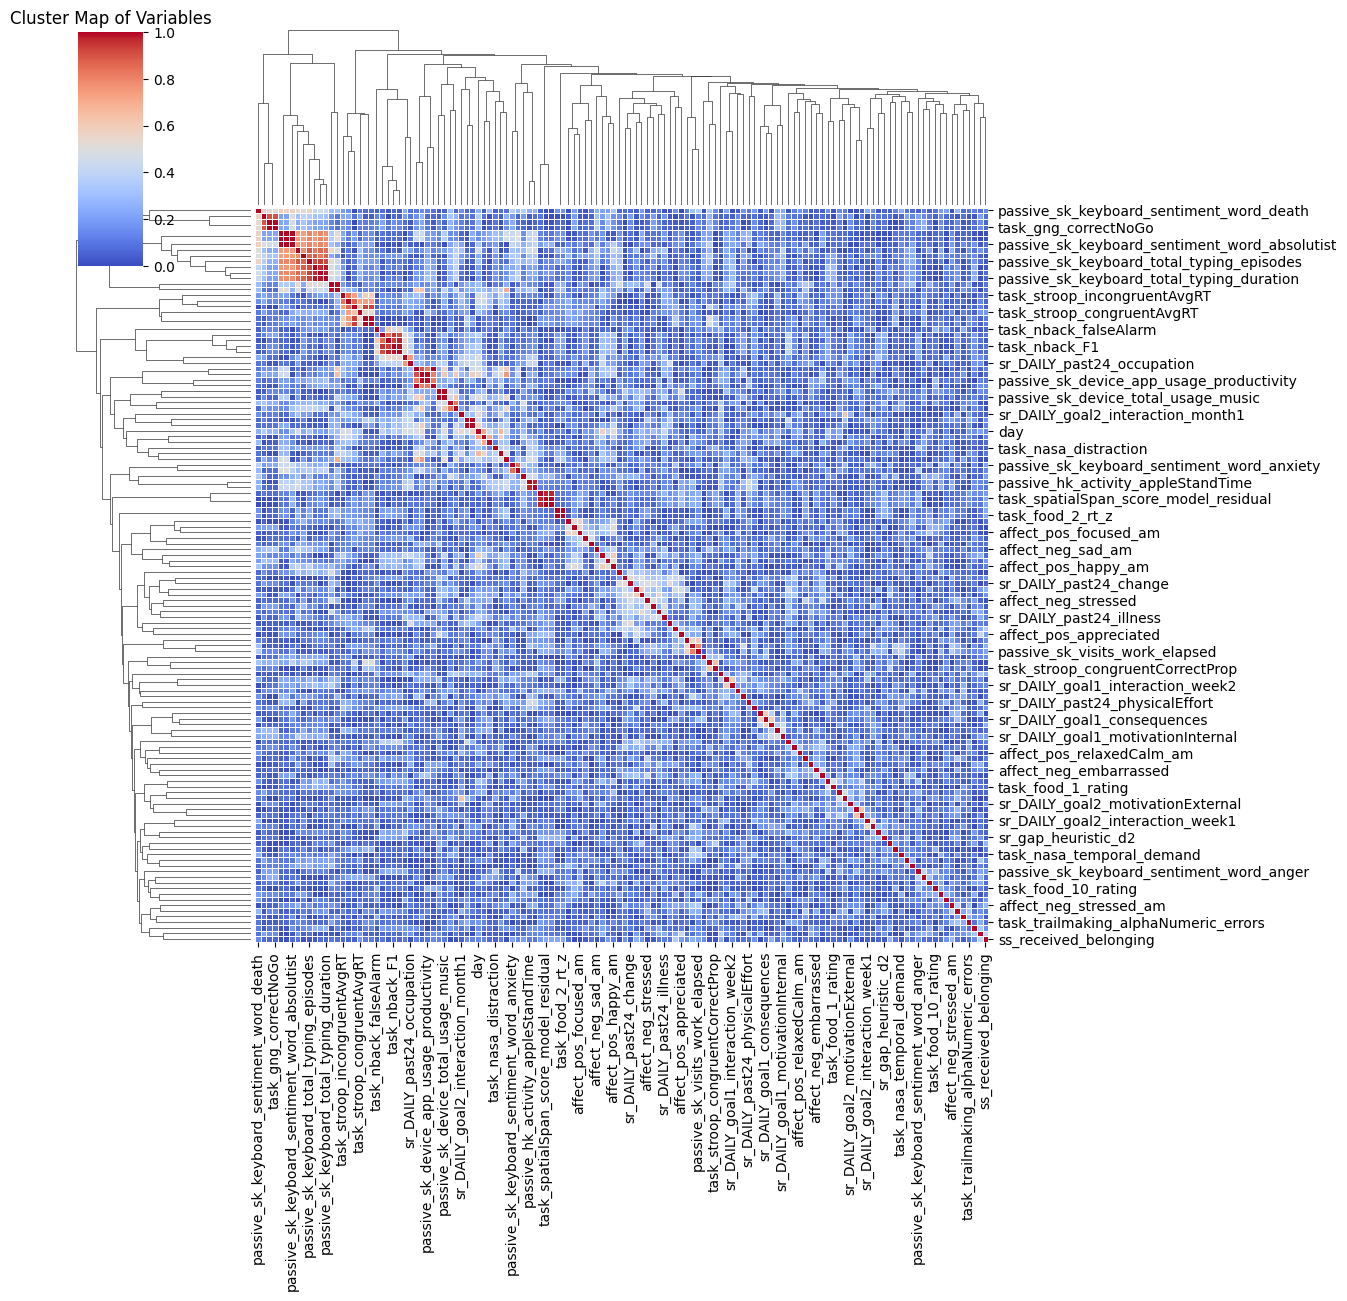

In [204]:
sns.clustermap(corr_matrix, figsize=(13, 13), cmap='coolwarm', linewidths=.5)
plt.title('Cluster Map of Variables')
plt.show()

In [178]:
# Set the correlation threshold
threshold = 0.8

# Identify pairs of highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop highly correlated columns
X = X.drop(to_drop, axis=1)

In [205]:
# Define the threshold
threshold = 0.8

# Create a mask to find correlations greater than the threshold, ignoring the diagonal
mask = abs(corr_matrix) > threshold
np.fill_diagonal(mask.values, False)

# Extract pairs above threshold
high_corr_pairs = corr_matrix[mask].stack()

# Format the output for better readability
formatted_pairs = pd.DataFrame(high_corr_pairs).reset_index()
formatted_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
formatted_pairs = formatted_pairs.drop_duplicates(subset=['Correlation'])

formatted_pairs

,Variable 1,Variable 2,Correlation
0,task_gng_incorrectNoGo,task_gng_correctNoGo,1.000000
1,task_gng_incorrectNoGo,task_gng_d_prime,0.902011
4,task_nback_accuracy,task_nback_recall,0.854351
5,task_nback_accuracy,task_nback_F1,0.935312
6,task_nback_accuracy,task_nback_MCC,0.973813
8,task_nback_recall,task_nback_F1,0.953046
9,task_nback_recall,task_nback_MCC,0.915386
12,task_nback_F1,task_nback_MCC,0.986979
16,task_stroop_totalAvgRT,task_stroop_incongruentAvgRT,0.837684
17,task_stroop_totalAvgRT,task_stroop_efficiency,0.869068


In [190]:
df_numeric.sr_DAILY_past24_socialMedia.var()

256.88627681457547

In [191]:
df_numeric.affect_neg_depressed_am.var()

0.023522662076878947

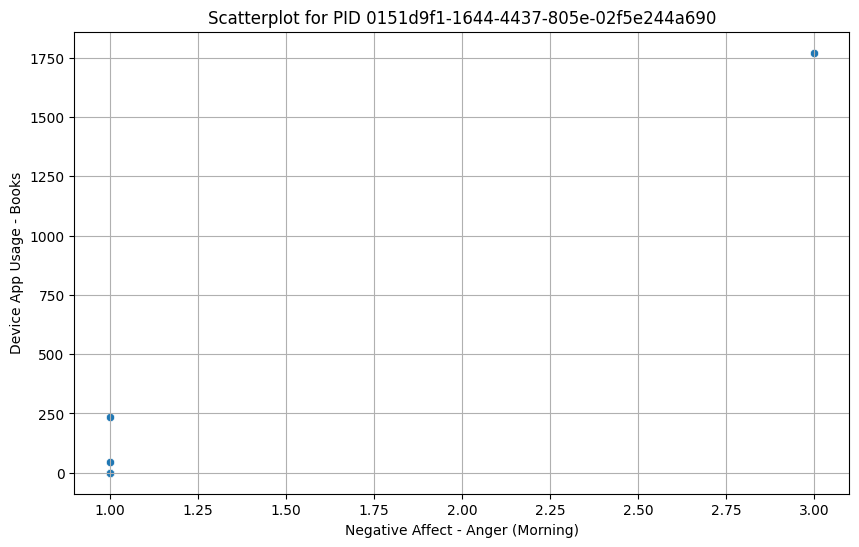

In [183]:
# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='affect_neg_angry_am', y='passive_sk_device_app_usage_books', data=df_numeric)

plt.title(f'Scatterplot for PID {subject}')
plt.xlabel('Negative Affect - Anger (Morning)')
plt.ylabel('Device App Usage - Books')
plt.grid(True)
plt.show()

In [186]:
df_numeric[['day', 'affect_neg_angry_am', 'passive_sk_device_app_usage_books', 'sr_gap_heuristic']].dropna()

,day,affect_neg_angry_am,passive_sk_device_app_usage_books,sr_gap_heuristic
0,1,1.0,0.0,5.00
1,2,1.0,0.0,15.25
2,3,1.0,0.0,46.35
3,4,1.0,0.0,43.70
4,5,1.0,0.0,45.60
5,6,1.0,0.0,11.55
6,7,1.0,0.0,4.10
7,8,1.0,46.0,17.35
8,9,1.0,0.0,6.55
9,10,1.0,0.0,2.20


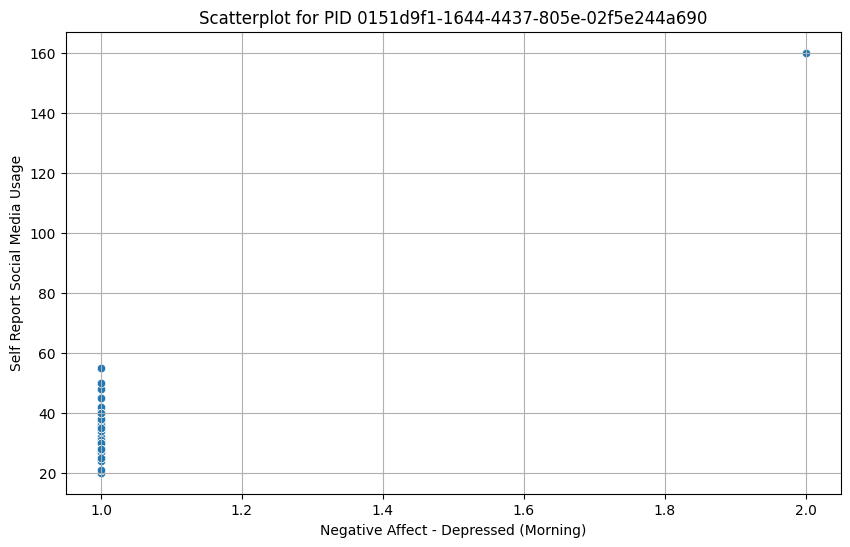

In [184]:
# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='affect_neg_depressed_am', y='sr_DAILY_past24_socialMedia', data=df_numeric)

plt.title(f'Scatterplot for PID {subject}')
plt.xlabel('Negative Affect - Depressed (Morning)')
plt.ylabel('Self Report Social Media Usage')
plt.grid(True)
plt.show()

In [187]:
df_numeric[['day', 'affect_neg_depressed_am', 'sr_DAILY_past24_socialMedia', 'sr_gap_heuristic']].dropna()

,day,affect_neg_depressed_am,sr_DAILY_past24_socialMedia,sr_gap_heuristic
0,1,2.0,160.0,5.00
1,2,1.0,55.0,15.25
2,3,1.0,35.0,46.35
3,4,1.0,45.0,43.70
4,5,1.0,30.0,45.60
...,...,...,...,...
79,80,1.0,28.0,25.95
80,81,1.0,25.0,4.05
81,82,1.0,28.0,19.50
82,83,1.0,45.0,31.95


## Feature Engineering
- window stats (e.g. 3 day, 7 day)
    - mean, SD, min, max
- `delta` features
    - day to day differences
    - day to week

## Two-Part Modeling

https://www.statmodel.com/download/DSEMFloorEffects.pdf

## Rolling Window Analysis
### Feature Engineering
- Local Statistics within the window

```
Rolling window cross-validation, also known as sliding or moving window cross-validation, is specifically designed for time-series data. It systematically shifts the training and validation sets forward in time, maintaining their relative position to one another, to simulate real-world scenarios where a model predicts future values based on past data.

How It Works:
Define Window Sizes:

Training Window: The amount of data included in each training set.
Validation Window: The amount of data used for validation in each iteration. This is usually much smaller than the training window.
Initialize Starting Point:

The initial model is trained on the first segment of the data (from the start up to a predefined point), and predictions are made over the next segment defined by the validation window.
Slide Windows Forward:

For each subsequent iteration, the training and validation windows are both shifted forward by a predefined step (often the size of the validation window). This progression mimics how the model would be used in practice, making predictions as new data becomes available.
Repeat Until Data Exhausted:

This process is repeated until the entire dataset has been used, or until enough iterations have been completed to satisfy the validation strategy.
Aggregate Results:

The performance metrics (like RMSE, MAE, AUC, etc.) are collected from each validation window and are typically summarized (e.g., averaged) to provide an overall assessment.
```

### Various ML Strategies
- Linear Regression
- XG Boost

## Ensemble models
Treat like MLM where the weighting of the models are the parameters

## Causality